# Business Understanding

A client wants to purchase a home in Westchester county and wants to ensure their home is a good investment. They measure that by ROI they will get in 10 years. Their budget is $500K. Our firm is asked to recommend 5 zipcodes in Westchester county that would be good options.

Metric: ROI (Return on Investment)

# Data Understanding

In [1]:
!pip install pmdarima


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# import relevant packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
import pmdarima as pm
import statsmodels.api as sm
%matplotlib inline

In [3]:
# Load the data and preview data
df=pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# Since we know we are only looking in Westchester county, let's filter our dataset for that

westchester_df = df[df['CountyName'] == 'Westchester']
westchester_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2141,61876,10583,Scarsdale,NY,New York,Westchester,2142,407700.0,409400.0,411300.0,...,1049800,1061100,1070100,1072900,1069300,1058200,1049700,1053400,1061900,1065400
2354,61905,10801,New Rochelle,NY,New York,Westchester,2355,214700.0,214800.0,214900.0,...,531000,536300,538700,537400,536400,537200,539100,537700,533000,530900
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800


In [5]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [6]:
df.shape

(14723, 272)

In [7]:
# Basic EDA: summary statistics, data types, and city distribution
print("Basic Statistics (non-date columns):")
non_date_columns = ['RegionID', 'RegionName', 'SizeRank']
print(westchester_df[non_date_columns].describe())

print("\nData Information:")
print(westchester_df.info())

print("\nTop 10 Cities by Frequency:")
print(westchester_df['City'].value_counts().head(10))


Basic Statistics (non-date columns):
           RegionID    RegionName      SizeRank
count     61.000000     61.000000     61.000000
mean   61866.573770  10593.065574   7988.196721
std       27.504217     83.122975   3416.616420
min    61817.000000  10501.000000    275.000000
25%    61843.000000  10533.000000   5843.000000
50%    61867.000000  10570.000000   8312.000000
75%    61891.000000  10605.000000  10334.000000
max    61909.000000  10805.000000  14621.000000

Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, 274 to 14620
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 130.1+ KB
None

Top 10 Cities by Frequency:
City
Yonkers            6
Somers             4
White Plains       3
New Rochelle       3
Mount Vernon       3
Lewisboro          2
Bedford            2
Cortlandt Manor    2
Greenburgh         2
Eastchester        2
Name: count, dtype: int64


In [8]:
# How many zip codes are in each city
zipcode_counts = westchester_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

                  City  Num_Zipcodes
0              Ardsley             1
1              Bedford             2
2     Briarcliff Manor             1
3            Chappaqua             2
4      Cortlandt Manor             2
5     Croton-on-Hudson             1
6          Dobbs Ferry             1
7          Eastchester             2
8             Elmsford             1
9       Goldens Bridge             1
10          Greenburgh             2
11            Harrison             1
12           Hartsdale             1
13  Hastings on Hudson             1
14           Hawthorne             1
15           Irvington             1
16           Larchmont             1
17           Lewisboro             2
18          Mamaroneck             1
19         Mount Kisco             1
20        Mount Vernon             3
21        New Rochelle             3
22        North Castle             1
23         North Salem             1
24            Ossining             1
25           Peekskill             1
2

# Data Preparation

In [9]:
filtered_df = westchester_df[westchester_df['2018-04'] <=500_000]

# Display the filtered DataFrame
filtered_df.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


In [10]:
zipcode_counts = filtered_df.groupby('City')['RegionName'].nunique().reset_index()
zipcode_counts.columns = ['City', 'Num_Zipcodes']
print(zipcode_counts)

              City  Num_Zipcodes
0  Cortlandt Manor             2
1         Elmsford             1
2   Goldens Bridge             1
3       Greenburgh             1
4     Mount Vernon             2
5         Ossining             1
6        Peekskill             1
7           Somers             2
8          Yonkers             4
9         Yorktown             2


In [11]:
# Check for null values
filtered_df.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [12]:
# Convert dates to datetime objects
def get_datetimes(df):
    """
    Takes a dataframe:
    Returns only those column names that can be converted into datetime objects
    as datetime objects.
    """
    date_columns = [col for col in df.columns if pd.to_datetime(col, format='%Y-%m', errors='coerce') is not pd.NaT]
    return pd.to_datetime(date_columns, format='%Y-%m')

# Run the function
datetime_columns = get_datetimes(filtered_df)
print(datetime_columns)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)


In [13]:
# rename columns
filtered_df = filtered_df.rename(columns={'RegionName': 'Zipcode'})
filtered_df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
274,61895,10701,Yonkers,NY,New York,Westchester,275,181700.0,181100.0,180600.0,...,439100,441900,444300,446300,448500,451400,454000,456500,458400,459800
2383,61899,10705,Yonkers,NY,New York,Westchester,2384,183800.0,183900.0,183900.0,...,455800,461100,465400,467800,470400,474400,476500,475400,475600,477400
2729,61857,10550,Mount Vernon,NY,New York,Westchester,2730,NaN,NaN,NaN,...,288100,289500,292200,295200,297600,299600,301600,304300,305000,304800
3164,61898,10704,Yonkers,NY,New York,Westchester,3165,174000.0,174000.0,173800.0,...,425400,430500,435600,439500,440800,442300,444800,446700,449200,452600
3472,61864,10562,Ossining,NY,New York,Westchester,3473,201200.0,201600.0,202000.0,...,417400,419600,420200,419700,417200,413800,412000,412100,414400,416900
4136,61886,10598,Yorktown,NY,New York,Westchester,4137,204700.0,205300.0,205800.0,...,444400,447800,450600,450400,447500,445100,444500,444600,445400,445800
4579,61865,10566,Peekskill,NY,New York,Westchester,4580,143200.0,143500.0,143700.0,...,272300,272800,271800,270200,268500,269400,271800,274400,278400,283400
5849,61897,10703,Yonkers,NY,New York,Westchester,5850,163800.0,163500.0,163200.0,...,411200,413400,415400,417000,418400,419200,419900,419400,420300,422800
6126,61889,10603,Greenburgh,NY,New York,Westchester,6127,216500.0,217100.0,217800.0,...,496500,495600,498100,498900,493500,488200,486400,488500,494200,499100
6617,61866,10567,Cortlandt Manor,NY,New York,Westchester,6618,181200.0,180800.0,180300.0,...,374200,373600,375400,376600,375900,376400,378600,380600,382700,385100


C:\Users\hrcoh\AppData\Local\Temp\ipykernel_12180\1464596883.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')


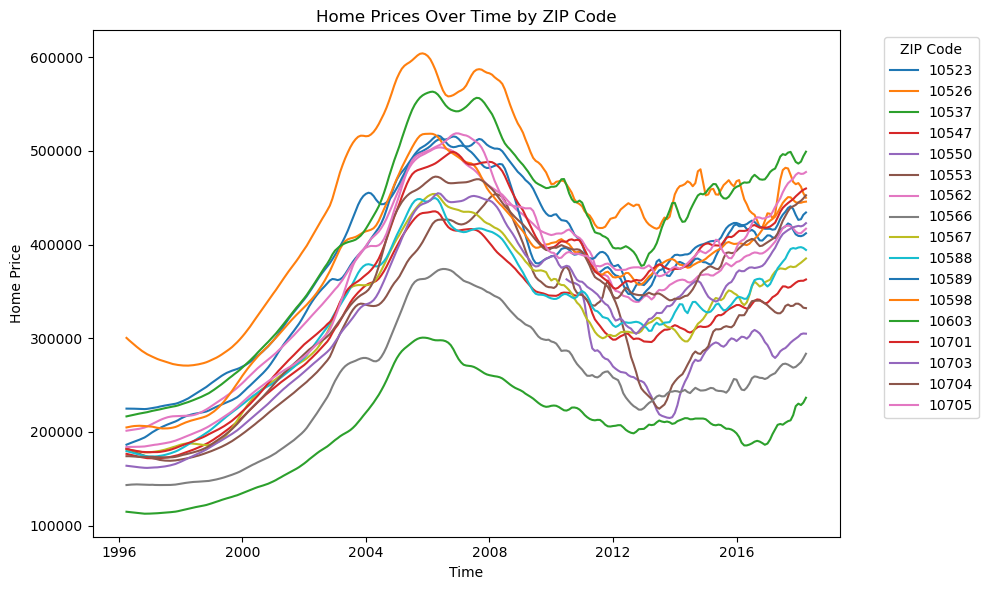

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Reshape the DataFrame
melted_df = pd.melt(filtered_df, id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName'], 
                    var_name='time', value_name='value')

# Step 2: Convert 'time' to datetime
melted_df['time'] = pd.to_datetime(melted_df['time'], errors='coerce')

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
for zipcode, group in melted_df.groupby('Zipcode'):
    plt.plot(group['time'], group['value'], label=str(zipcode))

plt.xlabel('Time')
plt.ylabel('Home Price')
plt.title('Home Prices Over Time by ZIP Code')
plt.legend(title='ZIP Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

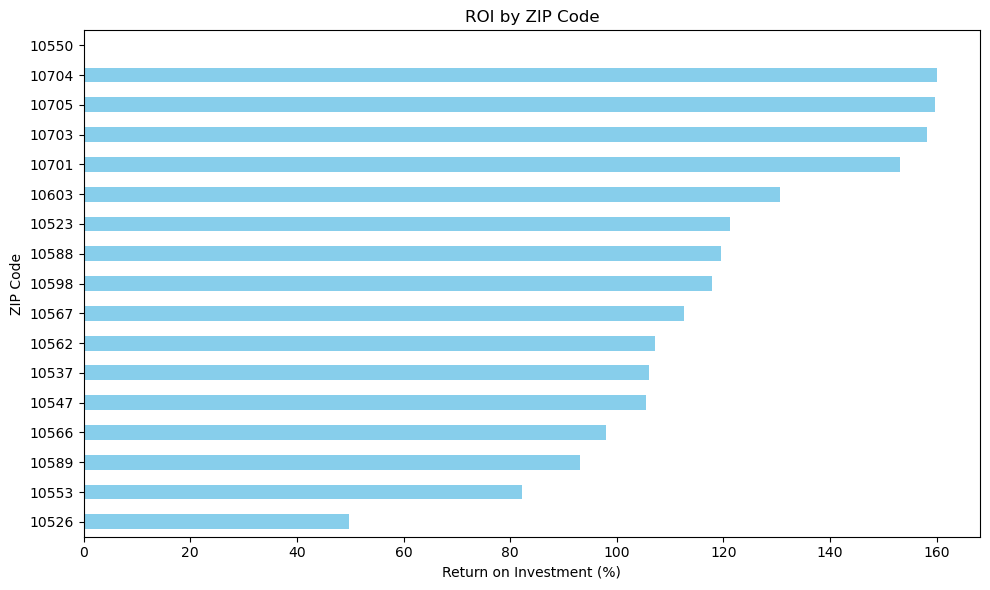

In [15]:
# Calculate ROI
pivot_df = melted_df.pivot_table(index='Zipcode', columns='time', values='value')
pivot_df['ROI'] = (pivot_df.iloc[:, -1] - pivot_df.iloc[:, 0]) / pivot_df.iloc[:, 0] * 100

plt.figure(figsize=(10, 6))
pivot_df['ROI'].sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Return on Investment (%)')
plt.ylabel('ZIP Code')
plt.title('ROI by ZIP Code')
plt.tight_layout()
plt.show()

To choose a zip code to build our model, we will use 10704 as the highest ROI.

In [22]:
def melt_data(df):
    # Select only the date columns for melting
    date_columns = [col for col in df.columns if isinstance(col, str) and '-' in col]
    melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName'], value_vars=date_columns, var_name='time', value_name='HomePrice')
    
    # Convert the 'time' column to datetime
    melted['time'] = pd.to_datetime(melted['time'], errors='coerce')
    
    # Drop rows where 'time' could not be converted
    melted = melted.dropna(subset=['time'])
    
    # Group by 'time' and calculate the mean 'HomePrice'
    result = melted.groupby('time')['HomePrice'].mean().reset_index()
    
    return result

In [23]:
# Filter for 10704
filtered_df_10704=filtered_df[filtered_df['Zipcode']==10704]

In [27]:
ts_10704=melt_data(filtered_df_10704)
ts_10704

,time,HomePrice
0,1996-04-01,174000.0
1,1996-05-01,174000.0
2,1996-06-01,173800.0
3,1996-07-01,173700.0
4,1996-08-01,173500.0
...,...,...
260,2017-12-01,442300.0
261,2018-01-01,444800.0
262,2018-02-01,446700.0
263,2018-03-01,449200.0


In [30]:
ts_10704['time'] = pd.to_datetime(ts_10704['time'])
ts_10704.set_index('time', inplace=True)

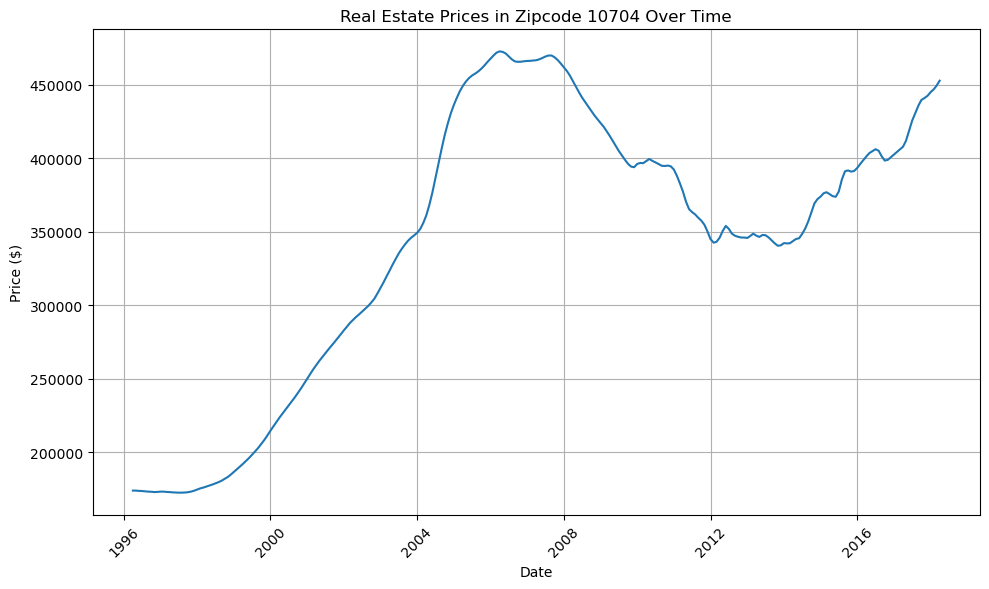

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(ts_10704)
plt.title('Real Estate Prices in Zipcode 10704 Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Arima Modeling

In [32]:
# Split data into train and test
train_size = int(len(ts_10704) * 0.8)
train, test = ts_10704.iloc[:train_size], ts_10704.iloc[train_size:]

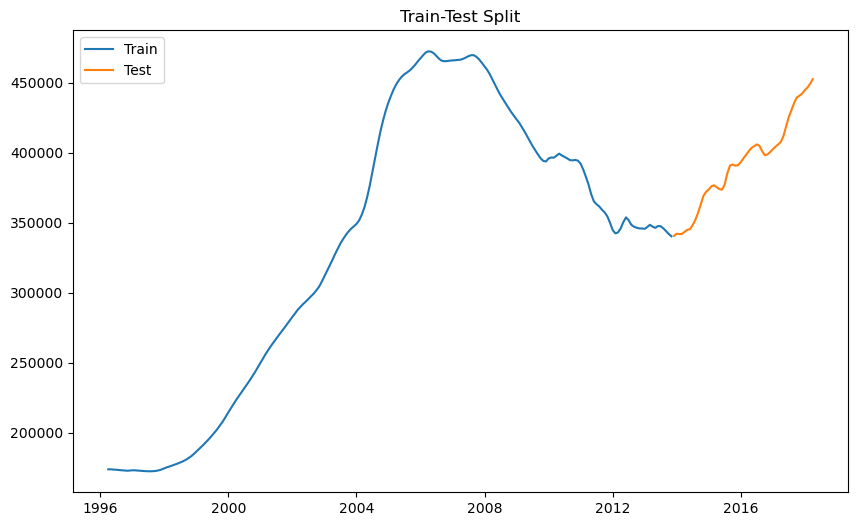

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [34]:
# Time Series Split on train
split=TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train Index: {train_ind}')
    print(f'Test Index: {val_ind}')

Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Test Index: [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70 71]
Train Index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Test Index: [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
Train Index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86

In [35]:
# baseline
train

,HomePrice
time,
1996-04-01,174000.0
1996-05-01,174000.0
1996-06-01,173800.0
1996-07-01,173700.0
1996-08-01,173500.0
...,...
2013-07-01,347600.0
2013-08-01,346100.0
2013-09-01,344100.0


# Auto Arima

In [36]:
auto_model = pm.auto_arima(
    train,         
    start_p=0,             # Starting value of p (AR order)
    start_q=0,             # Starting value of q (MA order)
    test='adf',            # Unit root test to check stationarity (ADF test)
    max_p=5,               # Maximum value of p
    max_q=5,               # Maximum value of q
    m=1,                   # Number of periods in each season (1 for non-seasonal data)
    d=0,                   # Order of non-seasonal differencing
    seasonal=True,         # Whether to include seasonal components
    start_P=0,             # Starting value of P (seasonal AR order)
    start_Q=0,             # Starting value of Q (seasonal MA order)
    D=0,                   # Order of seasonal differencing
    trace=True,            # Whether to print progress messages
    error_action='ignore', # Action to take when an error occurs ('ignore' to suppress)
    suppress_warnings=True # Whether to suppress warnings
)

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5493.197, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5334.572, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6012.289, Time=0.02 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5290.641, Time=0.07 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=3510.502, Time=0.28 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3401.652, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3422.804, Time=0.09 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3396.727, Time=0.25 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3393.869, Time=0.33 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3390.997, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3421.318, Time=0.21 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3423.005, Time=0.18 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=3420.383, Time=0.18 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=3394.616, Time=0.36 sec


C:\Users\hrcoh\anaconda3.0\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=3395.793, Time=0.27 sec

Best model:  ARIMA(4,0,2)(0,0,0)[0] intercept
Total fit time: 4.502 seconds


Best model:  ARIMA(4,0,2)

C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hrcoh\anaconda3.0\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.9532      0.114     25.891      0.000       2.730       3.177
ar.L2         -2.8472      0.359     -7.938      0.000      -3.550      -2.144
ar.L3          0.7867      0.396      1.988      0.047       0.011       1.562
ar.L4          0.1075      0.150      0.717      0.474      -0.186       0.401
ma.L1         -1.0456      0.075    -13.887      0.000      -1.193      -0.898
ma.L2         -0.5953      0.124     -4.810      0.000      -0.838      -0.353
sigma2      5.021e+05   3.88e-06   1.29e+11      0.000    5.02e+05    5.02e+05


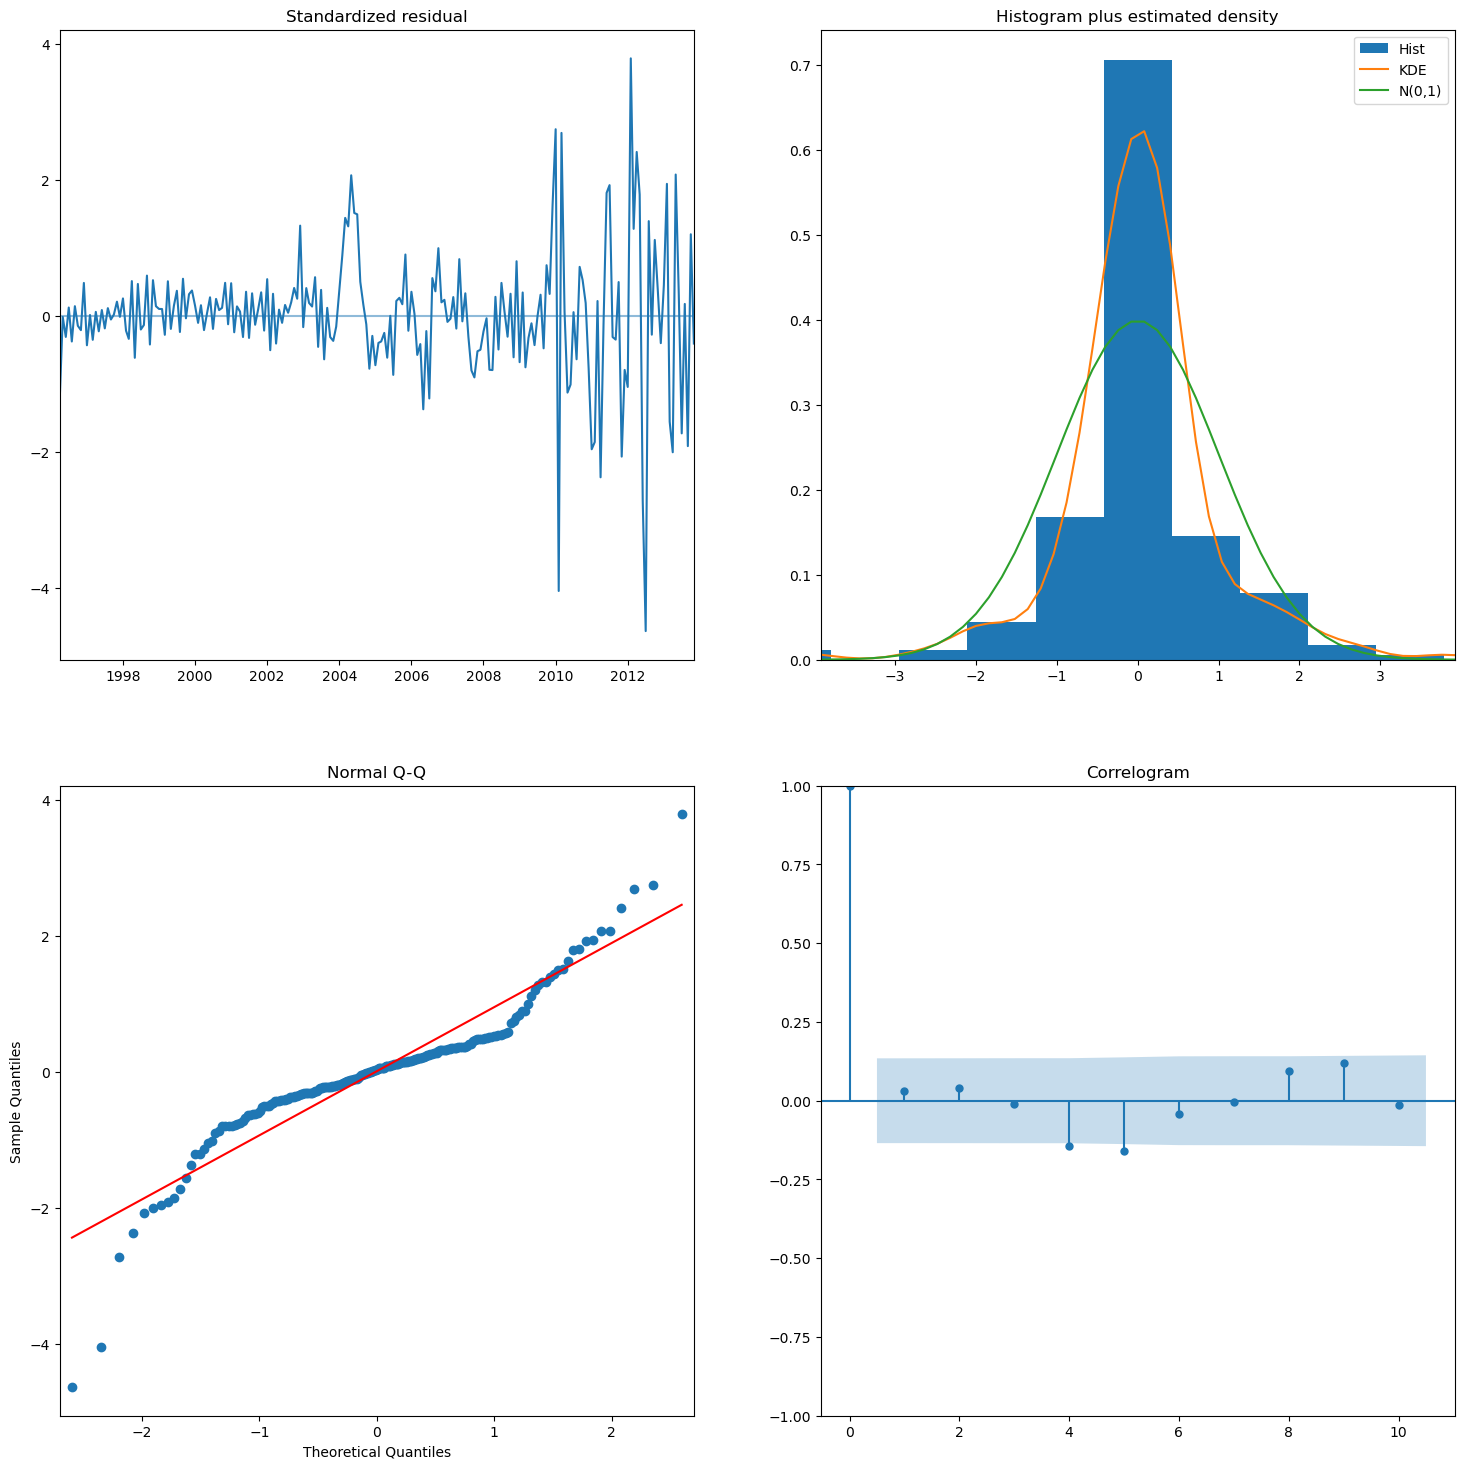

In [42]:
arima_model = sm.tsa.statespace.SARIMAX(train, 
                                        order=(4,0,2), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = arima_model.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

### Forecasting

In [48]:
# Forecast
in_sample_predictions = output.predict(start=train.index[0], end=train.index[-1])
out_of_sample_forecasts = output.forecast(steps=len(test))

# Calculate MAE
mae = mean_absolute_error(test, out_of_sample_forecasts)
print(f'Mean Absolute Error: {mae}')

# Calculate MSE
mse = mean_squared_error(test, out_of_sample_forecasts)
print(f'Mean Squared Error: {mse}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 36423.83095125295
Mean Squared Error: 2488124744.375034
Root Mean Squared Error: 49881.10608612277


## Evaluation